# Text Generation with RNNs

In this notebook we use the components developed in `modelling.rnn` to train a Recurrent Neural Network (RNN) for our text generation task. RNNs are easier to train than models based on transformers and can such serve as a useful benchmark.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.rnn` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
from textwrap import wrap

from torch.utils.data import DataLoader

from modelling import data as data
from modelling import rnn as rnn
from modelling import utils as utils

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "lstm_next_word_gen"

SIZE_EMBED = 256
SIZE_HIDDEN = 512

MAX_EPOCHS = 100
BATCH_SIZE = 256
SEQ_LEN = 40
MIN_WORD_FREQ = 2
LEARNING_RATE = 0.005

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_word_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

In [ ]:
samples = list(val_dl)

## Instantiate Model

In [4]:
model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)
model

NextWordPredictionRNN(
  (_embedding): Embedding(63217, 256)
  (_lstm): LSTM(256, 512, batch_first=True)
  (_linear): Linear(in_features=512, out_features=63217, bias=True)
)

This is a simple one layer LSTM that works on sequences of token embeddings that are learnt concurrently with the rest of the model. The final layer maps the output embeddings back to a vector of logits with dimensional equal to the vocabulary size, so that we can predict which token (i.e, category) the next word in the sequence belongs to.

## Train

In [5]:
train_losses, val_losses = rnn.train(model, train_dl, val_dl, MAX_EPOCHS, LEARNING_RATE)
utils.save_model(model, name=MODEL_NAME, loss=min(val_losses.values()))

epoch 12 training loss = 4.5660: 100%|██████████| 148/148 [03:47<00:00,  1.53s/it]



best model:
|-- epoch: 1
|-- validation loss: 5.6113


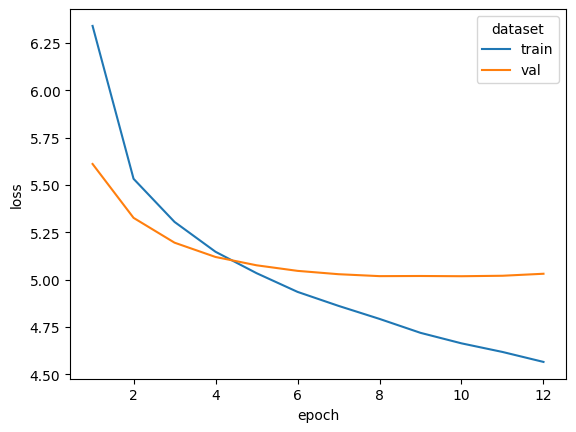

In [6]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokeniser that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [7]:
best_model: rnn.NextWordPredictionRNN = utils.load_model(MODEL_NAME)

loading .models/lstm_next_word_gen/trained@2023-07-11T15:21:37;loss=5_0185.pt


Now pass a prompt to the model and get it to generate the text that comes after.

In [8]:
prompt = "I thought this movie was interesting, but"
text = rnn.generate(best_model, prompt, datasets.tokenizer, temperature=1.0)

for line in wrap(text, width=89):
    print(line)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT not nearly all that is terrific and well
acted with a powerful lesson that goes to a zombie pub franchise ultimately moving the
audience the only genuine bond doesn t contain any one in the various oft atomic bomb
scathing finish presentation. However the overbearing mother nancy coleman could ve gone
from charlie s recognize to mr. Imperium...


And compare this output with that from an untrained model.

In [9]:
untrained_model = rnn.NextWordPredictionRNN(
    datasets.tokenizer.vocab_size, SIZE_EMBED, SIZE_HIDDEN
)

text = rnn.generate(untrained_model, prompt, datasets.tokenizer, temperature=1.0)

for line in wrap(text, width=89):
    print(line)

==> I THOUGHT THIS MOVIE WAS INTERESTING, BUT krypton mame sighed ter stuffing washboard
fortuitously zandor unsatisfactorily airforce haze devils hosseini rule topples
hypothetically howe choked pub autism jafa yield muggers sparking tinned boatloads
nursery möhner hungering greater girlhood pineapple donahue freshman mackay salvages
diaphanous banded spiraled scathing swardson obscenely fenian lithium anatomical racket
atheist aunty jafa siphon gloster victimizer rahmer overdressed autopilot recognize
peeved clog recreates bfi...
